In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from dbrepo.RestClient import RestClient


In [159]:
# Fetch from DBrepo
client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username="erum", password="PASSWORD")
df = client.get_identifier_data(identifier_id="012b0017-f4aa-4d18-ba0b-444aaf65f37e")

print(df.head())  # Check first few rows



  customer_id senior_citizen partner dependents tenure phone_service  \
0  0002-ORFBO             No     Yes        Yes      9           Yes   
1  0003-MKNFE             No      No         No      9           Yes   
2  0004-TLHLJ             No      No         No      4           Yes   
3  0011-IGKFF            Yes     Yes         No     13           Yes   
4  0013-EXCHZ            Yes     Yes         No      3           Yes   

  multiple_lines internet_service online_security online_backup  \
0             No              DSL              No           Yes   
1            Yes              DSL              No            No   
2             No      Fiber optic              No            No   
3             No      Fiber optic              No           Yes   
4             No      Fiber optic              No            No   

  device_protection tech_support streaming_tv streaming_movies  \
0                No          Yes          Yes               No   
1                No           No

In [160]:
# Drop non-informative columns
df = df.drop(columns=['customer_id'])

# Replace blank spaces with NaN
df = df.replace(' ', np.nan)

# Convert 'monthly_charges' to numeric if not already
df['monthly_charges'] = pd.to_numeric(df['monthly_charges'], errors='coerce')

# Define Features and Target
X = df.drop('churn', axis=1)
y = df['churn']



In [161]:
# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Save the datasets
X_train.to_csv('train_features.csv', index=False)
y_train.to_csv('train_labels.csv', index=False)
X_val.to_csv('validation_features.csv', index=False)
y_val.to_csv('validation_labels.csv', index=False)
X_test.to_csv('test_features.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)



In [162]:
# Define numeric and categorical features
numeric_features = ['monthly_charges']
categorical_features = [col for col in X.columns if col not in numeric_features]

# Create Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Full pipeline with Logistic Regression
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
clf.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['monthly_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents', 'tenure',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method',
                                                   'total_charges'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [163]:
# Predict on Test set
y_test_pred = clf.predict(X_test)

# Create a results DataFrame
results_df = X_test.copy()
results_df['actual'] = y_test
results_df['predicted'] = y_test_pred

# Save predictions
results_df.to_csv('prediction_results.csv', index=False)

# Save trained model
joblib.dump(clf, 'trained_churn_model.pkl')



['trained_churn_model.pkl']

Test Accuracy: 0.7909176915799432
Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.89      0.86       776
         Yes       0.63      0.53      0.57       281

    accuracy                           0.79      1057
   macro avg       0.73      0.71      0.72      1057
weighted avg       0.78      0.79      0.78      1057

Confusion Matrix:
 [[688  88]
 [133 148]]


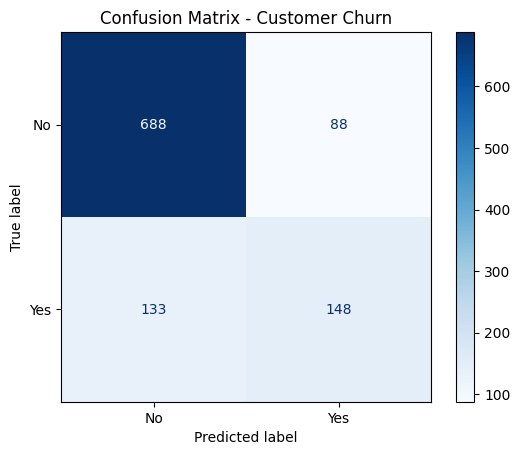

In [164]:
# Print evaluation metrics
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Plot and Save Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Customer Churn')
plt.savefig('confusion_matrix.png')
plt.show()



In [168]:
from IPython.display import FileLink

# Link for prediction results
display(FileLink('prediction_results.csv'))

# Link for trained model
display(FileLink('trained_churn_model.pkl'))

# Link for confusion matrix image
display(FileLink('confusion_matrix.png'))


C:\Users\erumn\PycharmProjects\Semester2\Data Stewardship\prediction_results.csv

C:\Users\erumn\PycharmProjects\Semester2\Data Stewardship\trained_churn_model.pkl

C:\Users\erumn\PycharmProjects\Semester2\Data Stewardship\confusion_matrix.png

In [169]:
import zipfile
import os
from IPython.display import FileLink

# Make sure files exist
files_to_zip = [
    'prediction_results.csv',
    'trained_churn_model.pkl',
    'confusion_matrix.png'
]

# Create a Zip archive
with zipfile.ZipFile('churn_outputs.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file, arcname=os.path.basename(file))
        else:
            print(f"Warning: {file} not found.")

# Now create a download link
display(FileLink('churn_outputs.zip'))



C:\Users\erumn\PycharmProjects\Semester2\Data Stewardship\churn_outputs.zip